In [4]:
from tensorflow.keras import layers
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import utils

In [18]:
IMG_SIZE = utils.IMG_SIZE
NUM_CLASSES = 16
BATCH_SIZE = 96

# The data is already split into train and test folders
# But, for good measure, split the train data into train(80%) and validation(20%)

data_dir = 'dataset_uniform/train'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=505,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  color_mode='grayscale')

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=505,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  color_mode='grayscale')

Found 350300 files belonging to 16 classes.
Using 280240 files for training.
Found 350300 files belonging to 16 classes.
Using 70060 files for validation.


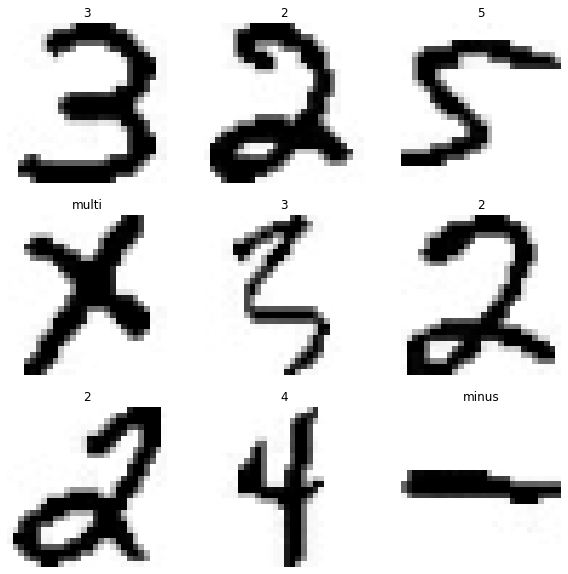

In [8]:
# Visualize 9 examples for a simple inspection

CLASS_NAMES = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"),cmap='gray')
        plt.title(CLASS_NAMES[int(labels[i])])
        plt.axis("off")

In [19]:
# Build a simple Sequential model, based on 

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


model = keras.Sequential()
model.add(layers.Input(shape=(IMG_SIZE,IMG_SIZE,1)))
model.add(layers.Conv2D(32, kernel_size=(3,3), padding='same', activation="relu"))
model.add(layers.MaxPool2D(pool_size=(3,3), strides=(3,3)))
model.add(layers.Conv2D(32, kernel_size=(2,2), padding='same', activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(200, activation="relu"))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(50, activation="relu"))
model.add(layers.Dense(NUM_CLASSES, activation="softmax"))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 9, 9, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 9, 9, 32)          4128      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 4, 4, 32)         0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 200)              

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=2, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True
)


model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

  
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks = [callback]
)

Epoch 1/10
2920/2920 [==============================] - 2711s 928ms/step - loss: 0.1510 - accuracy: 0.9576 - val_loss: 0.0765 - val_accuracy: 0.9781
Epoch 2/10
2920/2920 [==============================] - 196s 67ms/step - loss: 0.1029 - accuracy: 0.9714 - val_loss: 0.0692 - val_accuracy: 0.9805
Epoch 3/10
2920/2920 [==============================] - 209s 72ms/step - loss: 0.0881 - accuracy: 0.9756 - val_loss: 0.0588 - val_accuracy: 0.9833
Epoch 4/10
2920/2920 [==============================] - 269s 92ms/step - loss: 0.0786 - accuracy: 0.9781 - val_loss: 0.0538 - val_accuracy: 0.9845- loss: 0.0786 - ac
Epoch 5/10
2920/2920 [==============================] - 210s 72ms/step - loss: 0.0739 - accuracy: 0.9795 - val_loss: 0.0557 - val_accuracy: 0.9840
Epoch 6/10
2920/2920 [==============================] - 278s 95ms/step - loss: 0.0686 - accuracy: 0.9811 - val_loss: 0.0560 - val_accuracy: 0.9842
Epoch 00006: early stopping


In [10]:
model.save("model2")

INFO:tensorflow:Assets written to: model2\assets


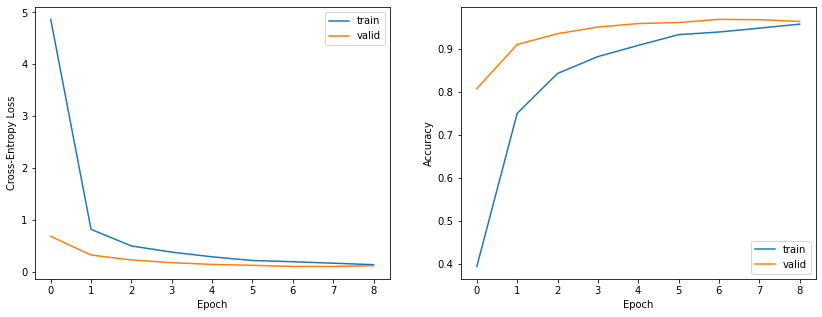

In [11]:

plt.figure(1, figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
data_dir = 'dataset_uniform/test'
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=505,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  color_mode='grayscale')

score = model.evaluate(test_ds, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Found 64721 files belonging to 16 classes.
675/675 [==============================] - 709s 1s/step - loss: 0.1347 - accuracy: 0.9652
Test loss: 0.13467204570770264
Test accuracy: 0.965173602104187


In [48]:
from sklearn.metrics import classification_report

batch = test_ds.take(25)

y_pred = np.array([])
y_true = np.array([])

wrong_imgs = {}

for img,label in batch:
    
    # Append true label to a list
    y_true = np.append(y_true,label.numpy())

    # Make a prediction and save it to another list
    pred = model.predict(img)
    pred = np.argmax(pred,axis=1)
    y_pred = np.append(y_pred, pred)

    # Save wrong predictions for later examination
    for i in range(BATCH_SIZE):
        true_label = label.numpy()[i]
        if true_label != pred[i]:
            
            true_label = CLASS_NAMES[true_label]
            pred_label = CLASS_NAMES[pred[i]]

            txt = "true %s | pred %s"%(true_label, pred_label)
            wrong_imgs[txt] = img[i]

y_true = y_true.astype('int64')



In [32]:
print(CLASS_NAMES)

['(', ')', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'div', 'minus', 'multi', 'plus']


In [29]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        97
           1       1.00      0.96      0.98       116
           2       0.99      0.99      0.99       158
           3       1.00      0.68      0.81       142
           4       0.99      0.96      0.98       159
           5       0.98      0.99      0.99       154
           6       0.97      0.96      0.97       133
           7       0.99      0.98      0.98       143
           8       0.98      1.00      0.99       141
           9       0.97      0.99      0.98       139
          10       0.99      0.98      0.98       133
          11       0.98      0.99      0.98       143
          12       0.87      1.00      0.93       299
          13       0.99      0.99      0.99       293
          14       0.96      1.00      0.98        70
          15       0.99      0.97      0.98        80

    accuracy                           0.97      2400
   macro avg       0.98   

In [33]:
print(tf.math.confusion_matrix(y_true,y_pred))

tf.Tensor(
[[ 97   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  3 111   1   0   0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   0 157   0   0   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0  97   0   0   1   0   1   1   0   0  42   0   0   0]
 [  0   0   0   0 153   2   0   0   0   1   1   0   1   0   1   0]
 [  0   0   0   0   1 153   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 128   0   0   1   0   2   0   0   2   0]
 [  0   0   0   0   0   0   0 140   1   0   0   0   0   2   0   0]
 [  0   0   0   0   0   0   0   0 141   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 138   0   0   0   1   0   0]
 [  0   0   0   0   0   1   0   1   0   0 130   1   0   0   0   0]
 [  0   0   0   0   0   0   1   1   0   0   0 141   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 299   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1 291   0   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0  

In [35]:
# Based on given results, its easy to see problems surrounding classes "1" and "div".
# It's not hard to imagine that the classes clash, because I've made the "div" class by augmenting "1"

# I think the model is pretty fine, I've tried out a couple of versions and they mostly end up around 95% accuracy on test_ds
# It was a great deal of work doing the image processing on my old PC, so I'll just settle with this model.
# It might be useful to try out newer models and different approaches - yolov4 could probably do wonders on detection and classification of digits, but I might be wrong

# To better the performance, the dataset would need to be filled with more diverse examples, and some examples should be removed
# I already picked trough a lot of images and preprocessed them to be more uniform in shape and size, but there's still awful examples
# 



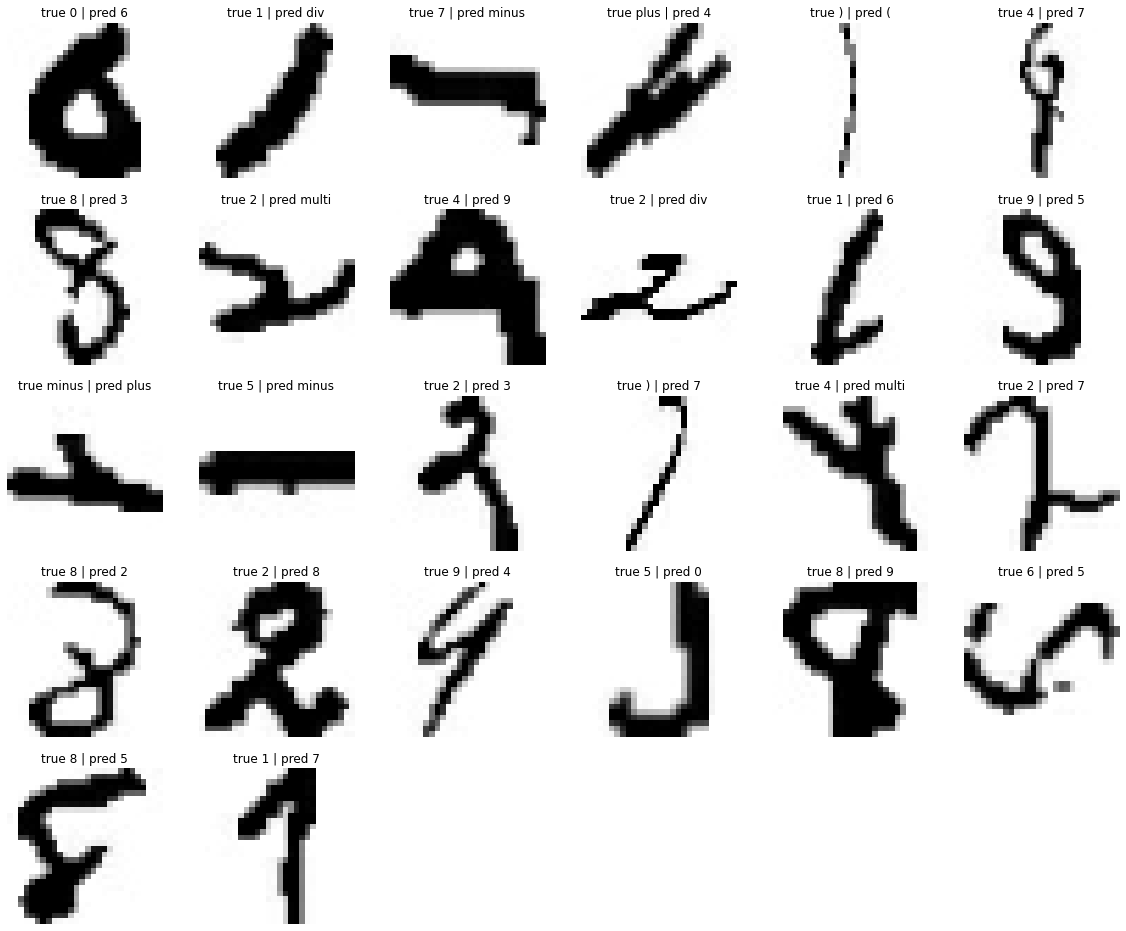

In [51]:
# Inspect wrong predictions

plt.figure(figsize=(20, 20))

for i,key in enumerate(wrong_imgs.keys()):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(wrong_imgs[key].numpy().astype("uint8"),cmap='gray')
    plt.title(key)
    plt.axis("off")

In [52]:
## There's some obvious examples of troublesome data, but also some examples of data that SHOULD be read correctly, such as:
# true 8 | pred 3
# true 9 | pred 5